# Machine Learning Final Project Models
Arun Mahtani, Isabelle Johnson, Brian Murphy

Packages

In [ ]:
# Standard python stuff
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from scipy.stats import pearsonr

# Modeling
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn import preprocessing

# seaborn figure params
sns.set(rc={'figure.figsize':(6,6), 'figure.dpi': 150})
sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})

Data

In [ ]:
# Data available at: https://www.kaggle.com/andrewmvd/heart-failure-clinical-data
# Related paper: https://bmcmedinformdecismak.biomedcentral.com/articles/10.1186/s12911-020-1023-5

heart_failure = pd.read_csv('https://raw.githubusercontent.com/bmurphy1993/NYU_ML_Final_Project/main/heart_failure_clinical_records_dataset.csv')

print(heart_failure.shape)
heart_failure.head()

(299, 13)


,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


Split continuous and binary variables

In [ ]:
binaries = ['anaemia', 'diabetes', 'high_blood_pressure', 'sex', 'smoking']
hf_continuous = heart_failure.drop(binaries, axis=1).drop(['DEATH_EVENT'], axis=1)
hf_continuous.head()

,age,creatinine_phosphokinase,ejection_fraction,platelets,serum_creatinine,serum_sodium,time
0,75.0,582,20,265000.00,1.9,130,4
1,55.0,7861,38,263358.03,1.1,136,6
2,65.0,146,20,162000.00,1.3,129,7
3,50.0,111,20,210000.00,1.9,137,7
4,65.0,160,20,327000.00,2.7,116,8


In [ ]:
hf_binaries = heart_failure[binaries].merge(heart_failure['DEATH_EVENT'], left_index=True, right_index=True)
hf_binaries.head()

,anaemia,diabetes,high_blood_pressure,sex,smoking,DEATH_EVENT
0,0,0,1,1,0,1
1,0,0,0,1,0,1
2,0,0,0,1,1,1
3,1,0,0,1,0,1
4,1,1,0,0,0,1


Standardized data

In [ ]:
# Standardize continuous variables with z-scores
hf_z = pd.DataFrame(preprocessing.scale(hf_continuous, axis=0), columns=hf_continuous.columns, index=hf_continuous.index)
hf_z = hf_z.merge(hf_binaries, left_index=True, right_index=True)
hf_z.head()

# Standardize with min-max
scaler = preprocessing.MinMaxScaler()
hf_minmax = pd.DataFrame(scaler.fit_transform(hf_continuous), columns=hf_continuous.columns, index=hf_continuous.index)
hf_minmax = hf_minmax.merge(hf_binaries, left_index=True, right_index=True)
hf_minmax.head()

,age,creatinine_phosphokinase,ejection_fraction,platelets,serum_creatinine,serum_sodium,time,anaemia,diabetes,high_blood_pressure,sex,smoking,DEATH_EVENT
0,0.636364,0.071319,0.090909,0.290823,0.157303,0.485714,0.000000,0,0,1,1,0,1
1,0.272727,1.000000,0.363636,0.288833,0.067416,0.657143,0.007117,0,0,0,1,0,1
2,0.454545,0.015693,0.090909,0.165960,0.089888,0.457143,0.010676,0,0,0,1,1,1
3,0.181818,0.011227,0.090909,0.224148,0.157303,0.685714,0.010676,1,0,0,1,0,1
4,0.454545,0.017479,0.090909,0.365984,0.247191,0.085714,0.014235,1,1,0,0,0,1


In [ ]:
# Create death label for figures
Death_Label = ['']*len(heart_failure)

for i in heart_failure.index:
  if heart_failure['DEATH_EVENT'][i] == 1:
    Death_Label[i] = 'Death'
  else:
    Death_Label[i] = 'No Death'

heart_failure['Death Label'] = Death_Label
heart_failure['Death Label'] = heart_failure['Death Label'].astype('category')

hf_z['Death Label'] = heart_failure['Death Label']
hf_minmax['Death Label'] = heart_failure['Death Label']

## Logistic Regression

Define function to print logistic regression results

In [ ]:
def log_reg(hf_data, data_name):
    # Train test split
  x_train, x_test, y_train, y_test = train_test_split(
      hf_data.drop(columns=['DEATH_EVENT', 'Death Label']), 
      hf_data['DEATH_EVENT'], 
      test_size=.3,
      random_state=46)

    # Train and predict
  lr = LogisticRegression(solver='lbfgs')
  clf = lr.fit(x_train, y_train)
  pred = clf.predict(x_test)
  y_scores = clf.decision_function(x_test)
  print('Predicted Class:\t', pred)
  print('Actual Class: \t\t', y_test.to_numpy())
  print('Accuracy: ', clf.score(x_test, y_test))

    # Confusion matrix
  disp = plot_confusion_matrix(clf, x_test, y_test,
                              display_labels=hf_data['Death Label'].cat.categories,
                              cmap=plt.cm.Blues,
                              normalize=None)
  disp.ax_.set_title('Test Data Confusion Matrix - {}\nAccuracy = {:.2f}'.format(data_name,clf.score(x_test, y_test)))
  disp.ax_.grid(False)
  disp.ax_.tick_params(axis='x')

  _ = disp.confusion_matrix

    # ROC curve
  ns_probs = [0 for _ in range(len(y_test))]
  lr_probs = lr.predict_proba(x_test)
  lr_probs = lr_probs[:, 1]
  ns_auc = roc_auc_score(y_test, ns_probs)
  lr_auc = roc_auc_score(y_test, lr_probs)
  ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
  lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
  plt.figure(figsize=(6,6))
  plt.plot(ns_fpr, ns_tpr, linestyle='--')
  plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic Regression\nAUC = {}'.format(round(lr_auc,3)))
  plt.title('Logistic Regression ROC Curve - {}'.format(data_name), fontdict={'fontsize': 14, 'fontweight':'bold'})
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.legend(loc="lower right", bbox_to_anchor=(.4, .8))
  plt.show()

Results with initial dataset

Predicted Class:	 [0 1 1 1 0 0 1 0 1 0 1 1 1 0 1 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 1 0 0 0 1 1
 0 0 0 1 0 0 0 1 0 0 1 1 0 0 1 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 0 1 0
 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0]
Actual Class: 		 [1 1 1 1 1 1 1 0 1 0 1 0 1 0 1 0 1 1 0 0 1 1 1 0 0 0 1 0 0 0 0 1 0 0 0 0 0
 0 1 0 1 0 0 0 1 0 0 0 1 0 1 1 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0
 0 0 0 1 0 0 1 0 0 0 1 0 0 0 1 0]
Accuracy:  0.8111111111111111


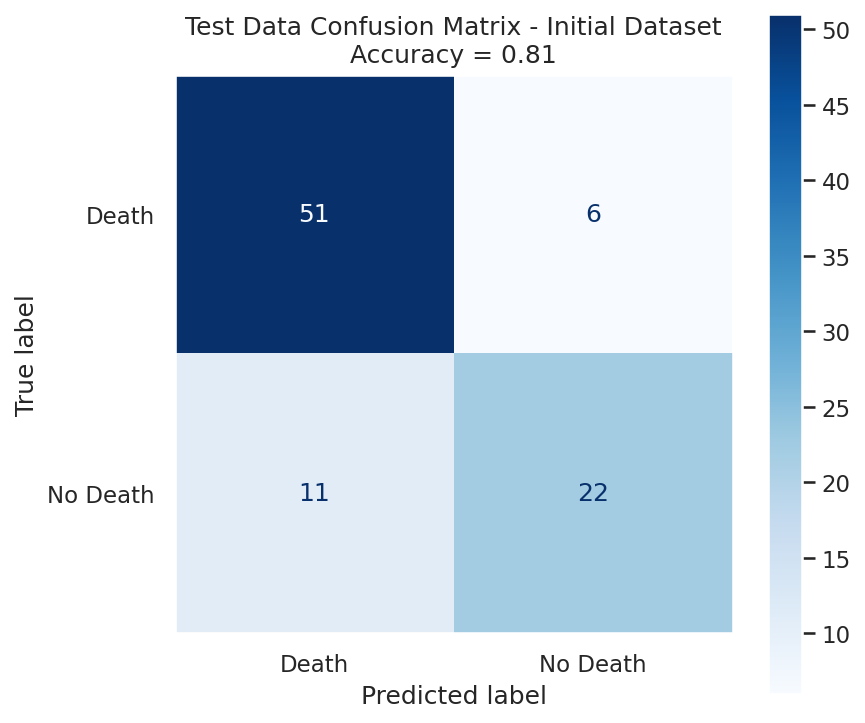

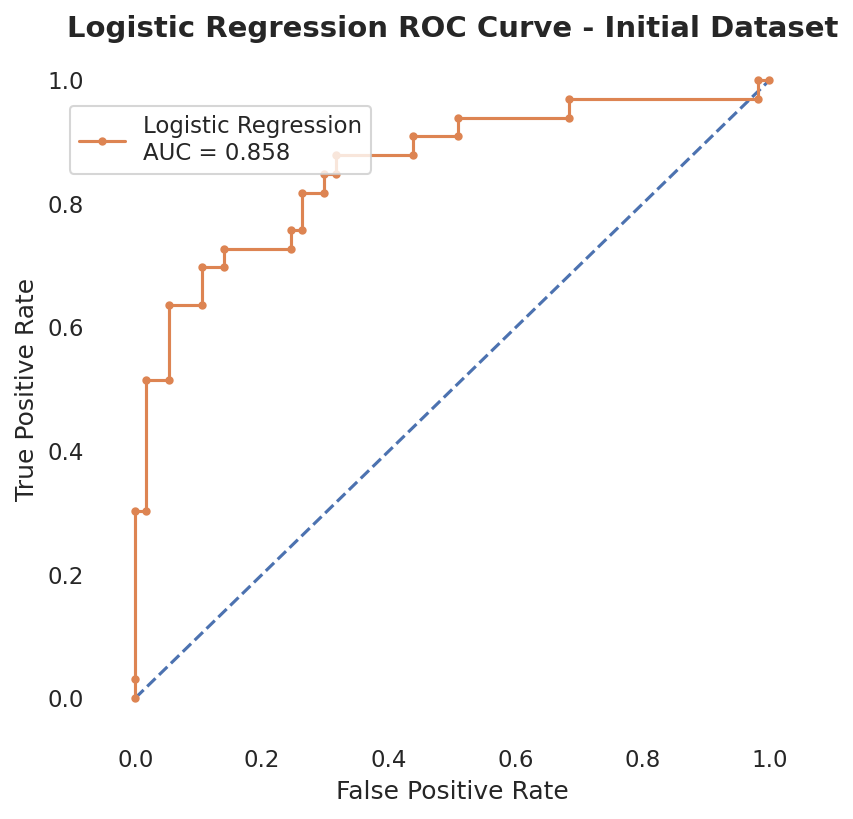

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
log_reg(heart_failure, 'Initial Dataset')
lr

Results with standardized data

Predicted Class:	 [0 1 1 1 0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 0 0 1 1 0 1 0 1 0 0 0 0 1 0 0 0 1 1
 0 1 0 1 0 0 0 1 0 0 1 1 0 0 1 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 0 1 0
 0 0 0 1 0 0 1 0 0 0 1 0 0 0 1 0]
Actual Class: 		 [1 1 1 1 1 1 1 0 1 0 1 0 1 0 1 0 1 1 0 0 1 1 1 0 0 0 1 0 0 0 0 1 0 0 0 0 0
 0 1 0 1 0 0 0 1 0 0 0 1 0 1 1 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0
 0 0 0 1 0 0 1 0 0 0 1 0 0 0 1 0]
Accuracy:  0.8666666666666667


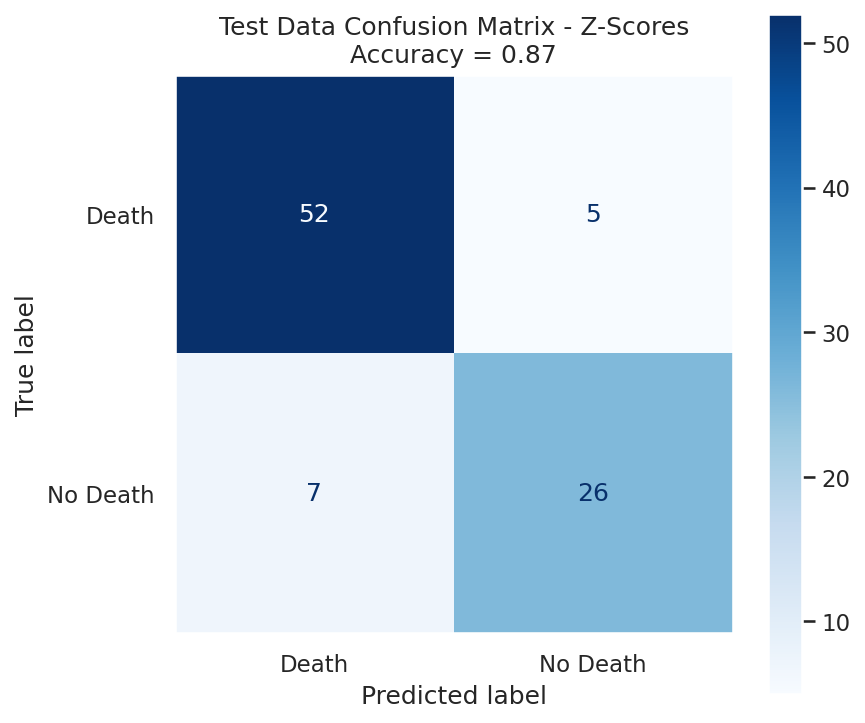

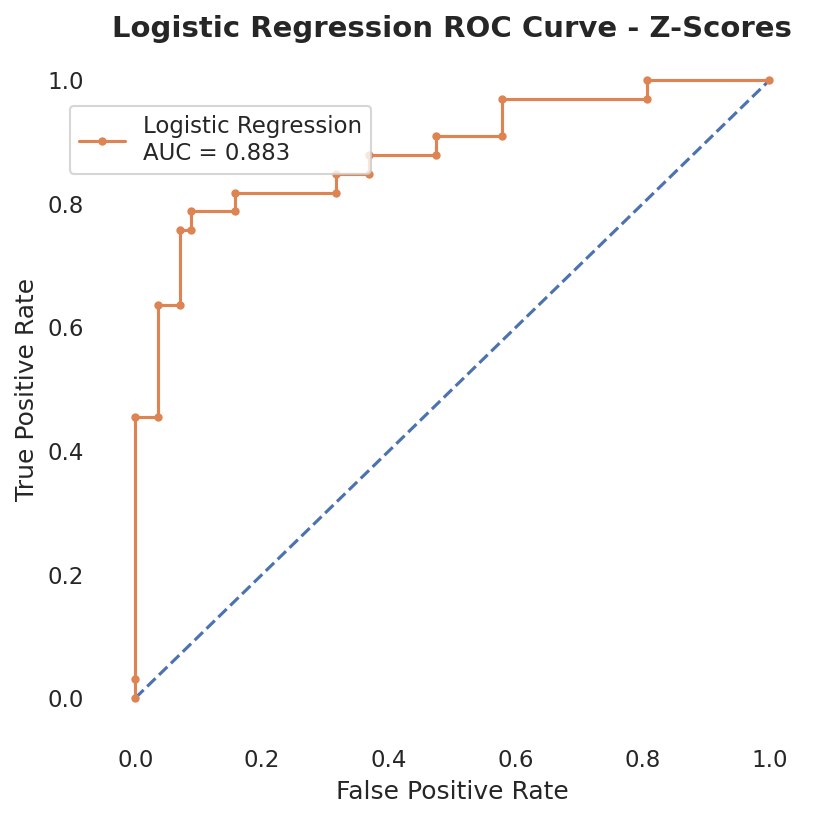

In [ ]:
log_reg(hf_z, 'Z-Scores')

Min-max Standardized

Predicted Class:	 [0 1 1 1 0 0 1 0 1 0 1 0 1 0 1 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 1
 0 0 0 1 0 0 0 1 0 0 1 1 0 0 1 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 0 1 0
 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0]
Actual Class: 		 [1 1 1 1 1 1 1 0 1 0 1 0 1 0 1 0 1 1 0 0 1 1 1 0 0 0 1 0 0 0 0 1 0 0 0 0 0
 0 1 0 1 0 0 0 1 0 0 0 1 0 1 1 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0
 0 0 0 1 0 0 1 0 0 0 1 0 0 0 1 0]
Accuracy:  0.8222222222222222


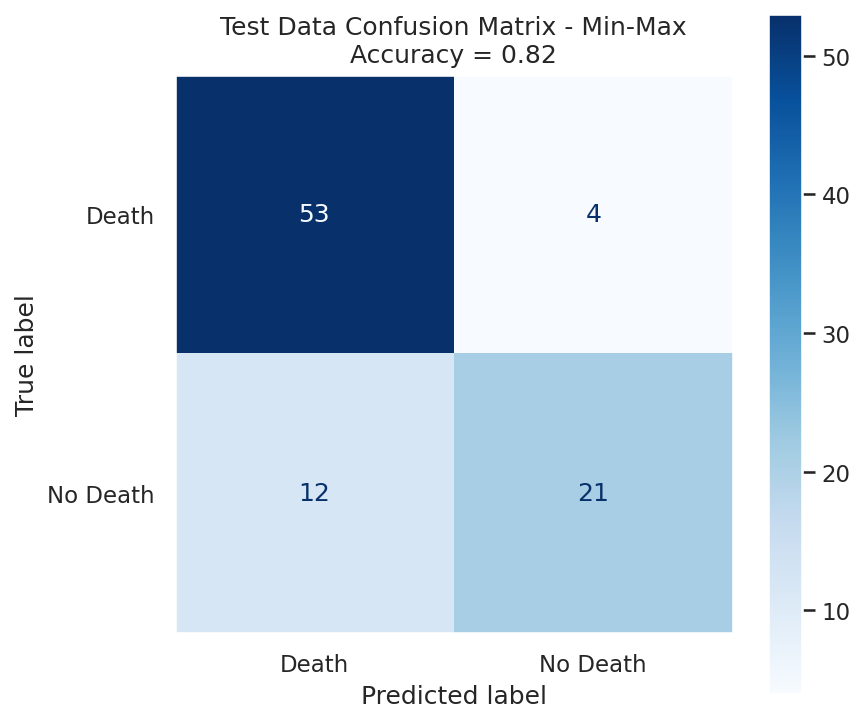

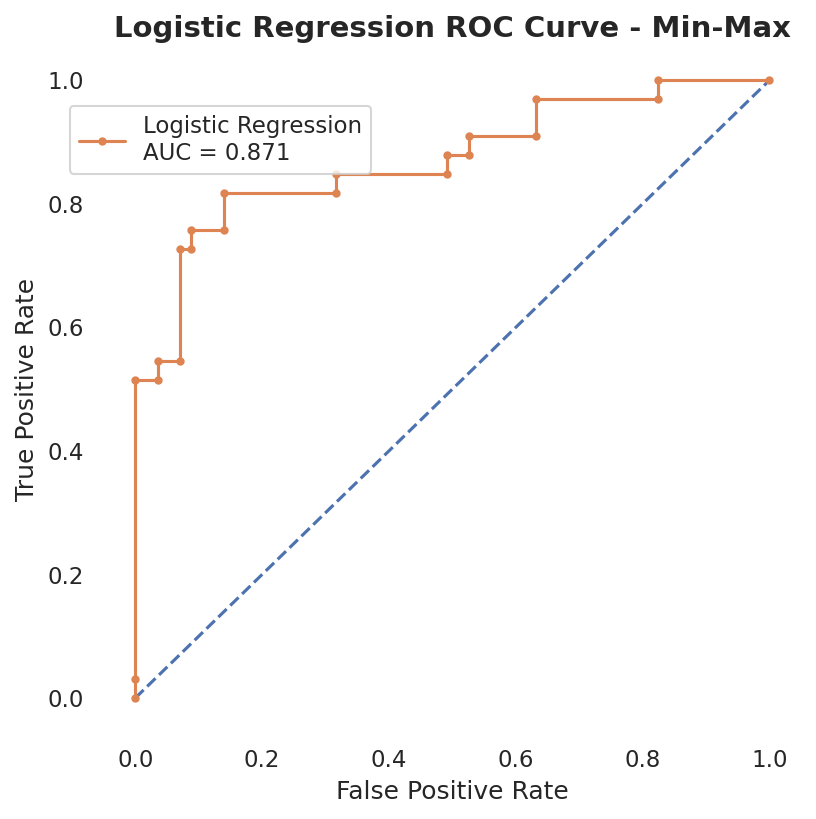

In [ ]:
hf_minmax = hf_minmax[['time', 'ejection_fraction', 'serum_creatinine', 'serum_sodium', 'age', 'DEATH_EVENT', 'Death Label']]
log_reg(hf_minmax, 'Min-Max')

##Feature Selection

age: 0.05931
anaemia: -0.00008
creatinine_phosphokinase: 0.00011
diabetes: 0.00052
ejection_fraction: -0.06687
high_blood_pressure: -0.00049
platelets: -0.00000
serum_creatinine: 0.00765
serum_sodium: 0.00348
sex: -0.00076
smoking: -0.00032
time: -0.02072


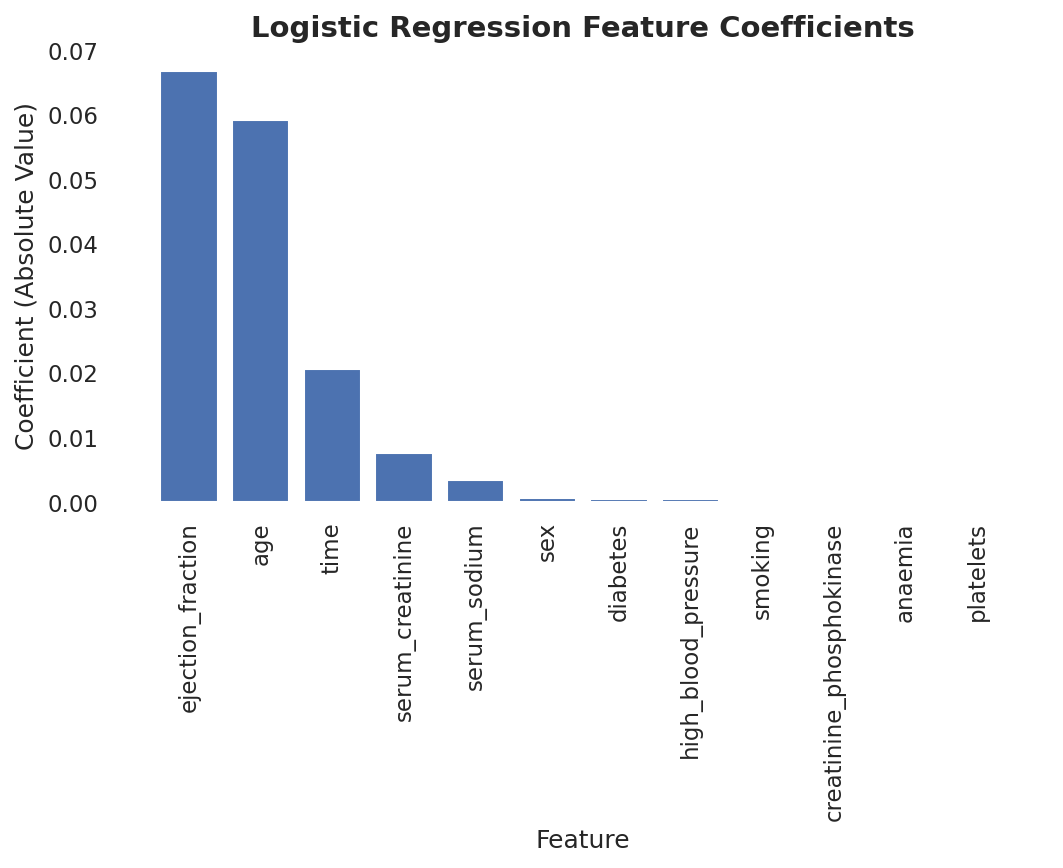

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(
    heart_failure.drop(columns=['DEATH_EVENT', 'Death Label']), 
    heart_failure['DEATH_EVENT'], 
    test_size=.2,
    random_state=42)

  # Train and predict
lr = LogisticRegression(random_state=0, solver='lbfgs')
lr.fit(x_train, y_train)

importance = lr.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
	print('{}: {:.5f}'.format(heart_failure.columns[i],v))

coefs_df = pd.DataFrame({'Features':heart_failure.columns[0:12], 'Coefs':abs(importance)}).sort_values(by='Coefs', ascending=False)


# plot feature importance
plt.figure(figsize=(8,4))
plt.bar(coefs_df['Features'], coefs_df['Coefs'])
plt.xticks(rotation=90)
plt.xlabel('Feature')
plt.ylabel('Coefficient (Absolute Value)')
plt.title('Logistic Regression Feature Coefficients', fontdict={'fontsize':14, 'fontweight':'bold'})
plt.show()

Predicted Class:	 [0 1 1 1 0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 0 0 1 1 0 1 0 1 0 0 0 0 1 0 0 0 0 1
 0 0 0 1 0 0 0 1 0 0 1 1 0 0 1 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 0 1 0
 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0]
Actual Class: 		 [1 1 1 1 1 1 1 0 1 0 1 0 1 0 1 0 1 1 0 0 1 1 1 0 0 0 1 0 0 0 0 1 0 0 0 0 0
 0 1 0 1 0 0 0 1 0 0 0 1 0 1 1 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0
 0 0 0 1 0 0 1 0 0 0 1 0 0 0 1 0]
Accuracy:  0.8555555555555555


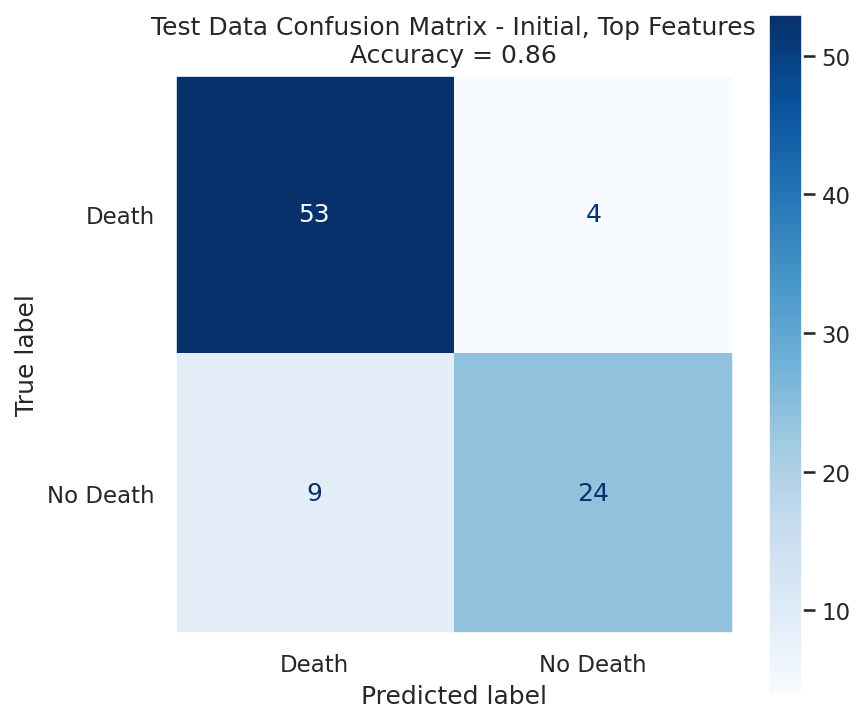

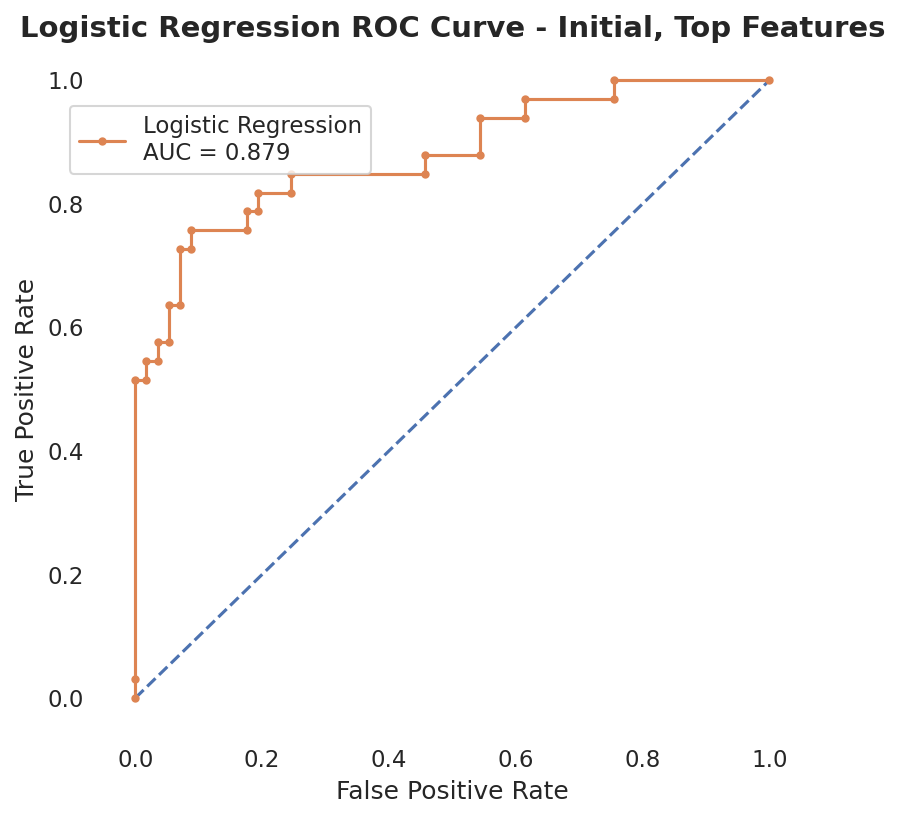

In [ ]:
# top 5 features based on coefficients from Logistic Regression
hf_tops = heart_failure[['time', 'ejection_fraction', 'serum_creatinine', 'serum_sodium', 'age', 'DEATH_EVENT', 'Death Label']]
log_reg(hf_tops, 'Initial, Top Features')

Predicted Class:	 [0 1 1 1 0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 0 0 1 1 0 1 0 1 0 0 0 0 1 0 0 0 0 1
 0 0 0 1 0 0 0 1 0 0 1 1 0 0 1 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 0 1 0
 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0]
Actual Class: 		 [1 1 1 1 1 1 1 0 1 0 1 0 1 0 1 0 1 1 0 0 1 1 1 0 0 0 1 0 0 0 0 1 0 0 0 0 0
 0 1 0 1 0 0 0 1 0 0 0 1 0 1 1 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0
 0 0 0 1 0 0 1 0 0 0 1 0 0 0 1 0]
Accuracy:  0.8555555555555555


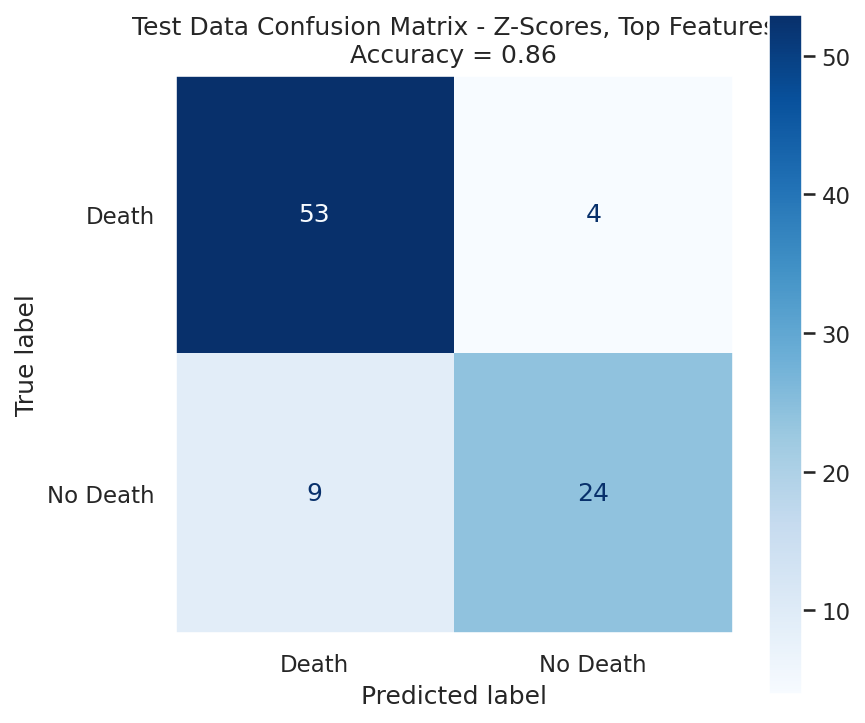

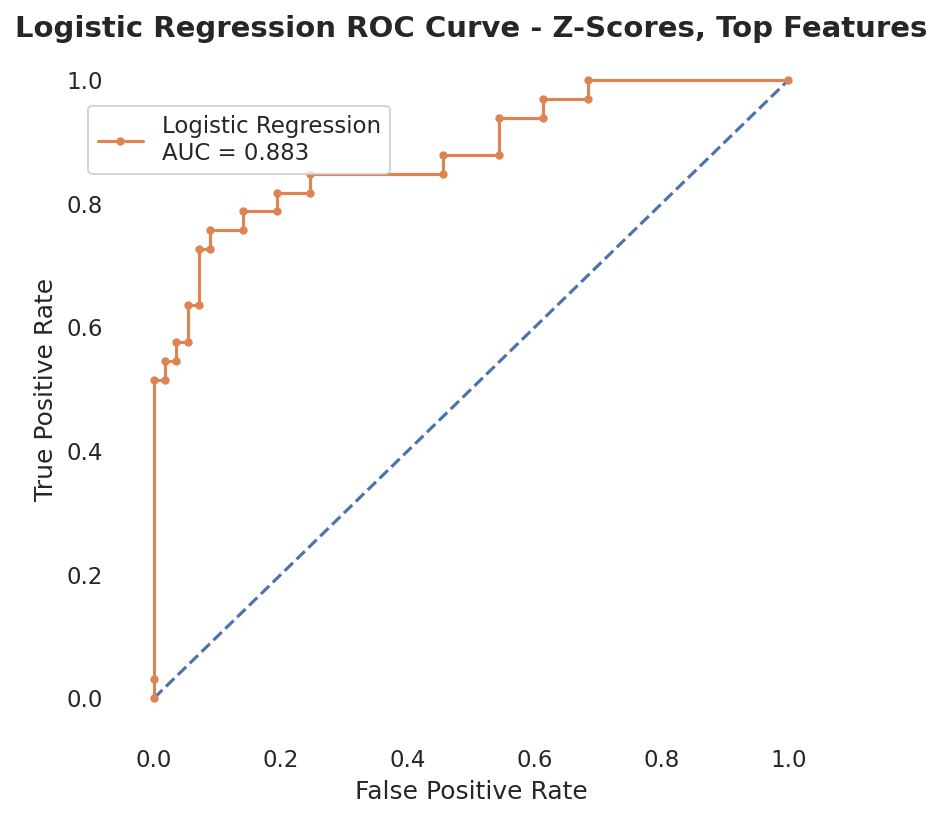

In [ ]:
# Top 5 features, z score standardized
hf_z_tops = hf_z[['time', 'ejection_fraction', 'serum_creatinine', 'serum_sodium', 'age', 'DEATH_EVENT', 'Death Label']]
log_reg(hf_z_tops, 'Z-Scores, Top Features')

Predicted Class:	 [0 1 1 1 0 0 1 0 1 0 1 0 1 0 1 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 1
 0 0 0 1 0 0 0 1 0 0 1 1 0 0 1 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 0 1 0
 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0]
Actual Class: 		 [1 1 1 1 1 1 1 0 1 0 1 0 1 0 1 0 1 1 0 0 1 1 1 0 0 0 1 0 0 0 0 1 0 0 0 0 0
 0 1 0 1 0 0 0 1 0 0 0 1 0 1 1 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0
 0 0 0 1 0 0 1 0 0 0 1 0 0 0 1 0]
Accuracy:  0.8222222222222222


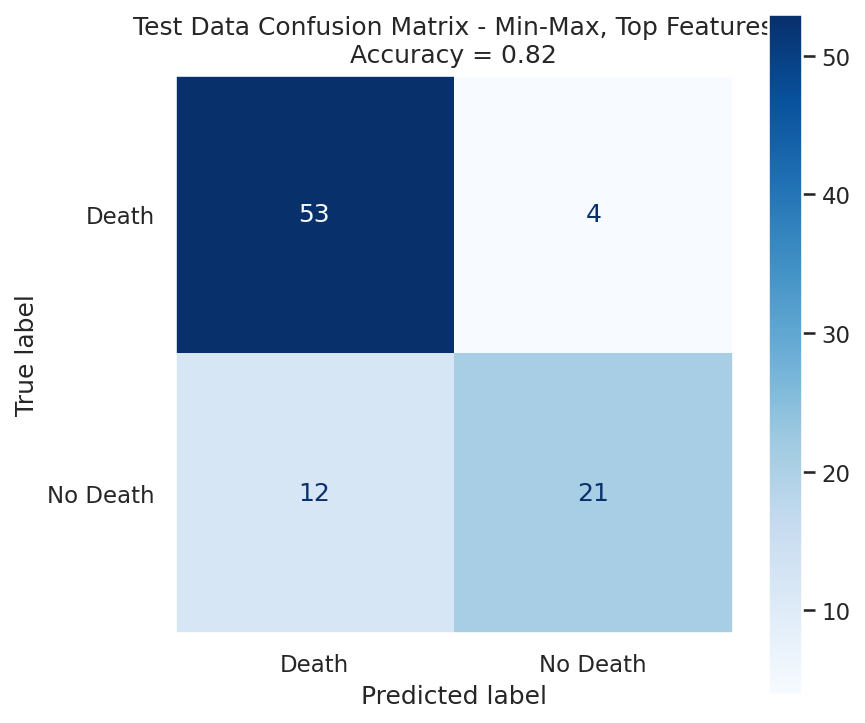

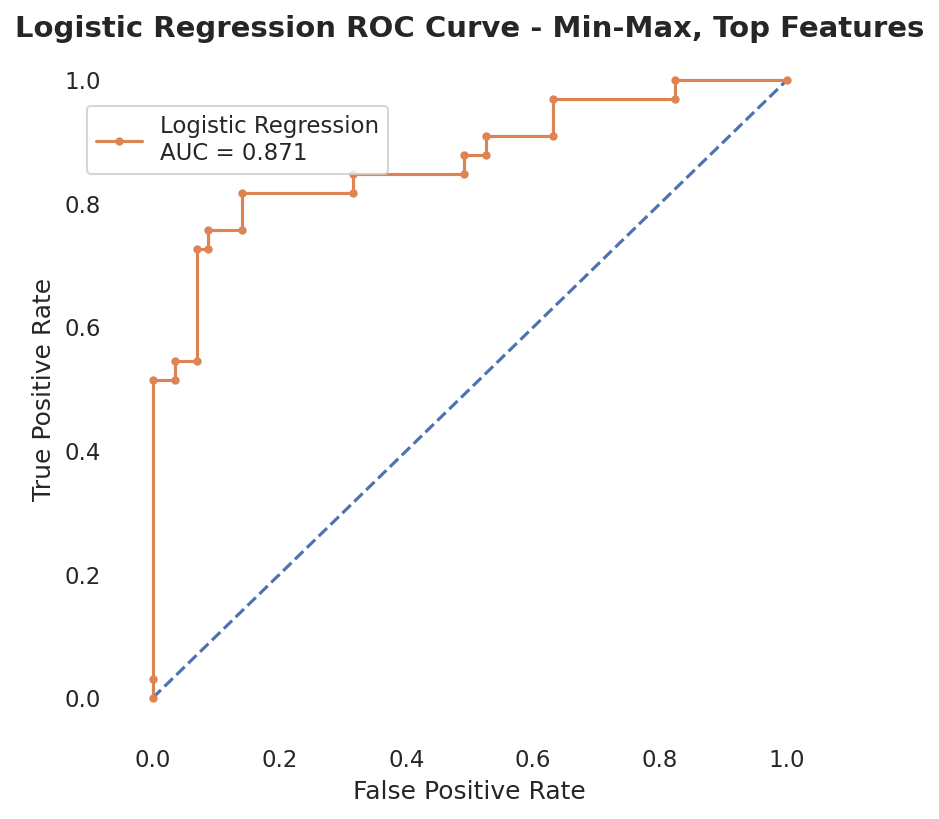

In [ ]:
# Top 5 features, min-max standardized
hf_mm_tops = hf_minmax[['time', 'ejection_fraction', 'serum_creatinine', 'serum_sodium', 'age', 'DEATH_EVENT', 'Death Label']]
log_reg(hf_mm_tops, 'Min-Max, Top Features')

##Cross Validation

Leave-one-out

In [ ]:
# Leave one out cross validation using scikit

def leaveoneout(hf_data):
  loo = LeaveOneOut()
  loo.get_n_splits(hf_data)

  max_probs = []

  prediction = []
  for train_index, test_index in loo.split(hf_data):
      hf_data, 
      hf_data
      X_train = hf_data.iloc[train_index].drop(columns=['DEATH_EVENT', 'Death Label'])
      X_test = hf_data.iloc[test_index].drop(columns=['DEATH_EVENT', 'Death Label'])
      y_train = hf_data.iloc[train_index]['DEATH_EVENT']
      y_test = hf_data.iloc[test_index]['DEATH_EVENT']
      
      lr = LogisticRegression(solver='lbfgs', max_iter=250)
      clf = lr.fit(X_train, y_train)
      prediction.append(clf.score(X_test, y_test))
      max_probs.append(max(clf.predict_proba(X_test)[0]))

leaveoneout(heart_failure)
hf_loo = heart_failure
hf_loo['Loo_pred'] = prediction
hf_loo_success = hf_loo[hf_loo['Loo_pred'] == 1.0]
hf_loo_fail = hf_loo[hf_loo['Loo_pred'] == 0.0]
print('Initial: ', sum(prediction) / len(prediction))
print('Success % Death Event: ', sum(hf_loo_success['DEATH_EVENT']) / len(hf_loo_success))
print('Failed % Death Event: ', sum(hf_loo_fail['DEATH_EVENT']) / len(hf_loo_fail),'\n')

leaveoneout(hf_z)
hf_loo = heart_failure
hf_loo['Loo_pred'] = prediction
hf_loo_success = hf_loo[hf_loo['Loo_pred'] == 1.0]
hf_loo_fail = hf_loo[hf_loo['Loo_pred'] == 0.0]
print('Z-scores: ', sum(prediction) / len(prediction))
print('Success % Death Event: ', sum(hf_loo_success['DEATH_EVENT']) / len(hf_loo_success))
print('Failed % Death Event: ', sum(hf_loo_fail['DEATH_EVENT']) / len(hf_loo_fail),'\n')

leaveoneout(hf_minmax)
hf_loo = heart_failure
hf_loo['Loo_pred'] = prediction
hf_loo_success = hf_loo[hf_loo['Loo_pred'] == 1.0]
hf_loo_fail = hf_loo[hf_loo['Loo_pred'] == 0.0]
print('Min-Max: ', sum(prediction) / len(prediction))
print('Success % Death Event: ', sum(hf_loo_success['DEATH_EVENT']) / len(hf_loo_success))
print('Failed % Death Event: ', sum(hf_loo_fail['DEATH_EVENT']) / len(hf_loo_fail),'\n')

leaveoneout(hf_tops)
hf_loo = heart_failure
hf_loo['Loo_pred'] = prediction
hf_loo_success = hf_loo[hf_loo['Loo_pred'] == 1.0]
hf_loo_fail = hf_loo[hf_loo['Loo_pred'] == 0.0]
print('Initial, top 5: ', sum(prediction) / len(prediction))
print('Success % Death Event: ', sum(hf_loo_success['DEATH_EVENT']) / len(hf_loo_success))
print('Failed % Death Event: ', sum(hf_loo_fail['DEATH_EVENT']) / len(hf_loo_fail),'\n')

leaveoneout(hf_z_tops)
hf_loo = heart_failure
hf_loo['Loo_pred'] = prediction
hf_loo_success = hf_loo[hf_loo['Loo_pred'] == 1.0]
hf_loo_fail = hf_loo[hf_loo['Loo_pred'] == 0.0]
print('Z-scores, top 5: ', sum(prediction) / len(prediction))
print('Success % Death Event: ', sum(hf_loo_success['DEATH_EVENT']) / len(hf_loo_success))
print('Failed % Death Event: ', sum(hf_loo_fail['DEATH_EVENT']) / len(hf_loo_fail),'\n')

leaveoneout(hf_mm_tops)
hf_loo = heart_failure
hf_loo['Loo_pred'] = prediction
hf_loo_success = hf_loo[hf_loo['Loo_pred'] == 1.0]
hf_loo_fail = hf_loo[hf_loo['Loo_pred'] == 0.0]
print('Min-Max, top 5: ', sum(prediction) / len(prediction))
print('Success % Death Event: ', sum(hf_loo_success['DEATH_EVENT']) / len(hf_loo_success))
print('Failed % Death Event: ', sum(hf_loo_fail['DEATH_EVENT']) / len(hf_loo_fail),'\n')

Initial:  0.822742474916388
Success % Death Event:  0.25203252032520324
Failed % Death Event:  0.6415094339622641 

Z-scores:  0.822742474916388
Success % Death Event:  0.25203252032520324
Failed % Death Event:  0.6415094339622641 

Min-Max:  0.822742474916388
Success % Death Event:  0.25203252032520324
Failed % Death Event:  0.6415094339622641 

Initial, top 5:  0.822742474916388
Success % Death Event:  0.25203252032520324
Failed % Death Event:  0.6415094339622641 

Z-scores, top 5:  0.822742474916388
Success % Death Event:  0.25203252032520324
Failed % Death Event:  0.6415094339622641 

Min-Max, top 5:  0.822742474916388
Success % Death Event:  0.25203252032520324
Failed % Death Event:  0.6415094339622641 



Evaluate with different random seeds

In [ ]:
def log_reg_lite(hf_data, rand):
    # Train test split
  x_train, x_test, y_train, y_test = train_test_split(
      hf_data.drop(columns=['DEATH_EVENT', 'Death Label']), 
      hf_data['DEATH_EVENT'], 
      test_size=.3,
      random_state=rand)

    # Train and predict
  lr = LogisticRegression(solver='lbfgs', max_iter=250)
  clf = lr.fit(x_train, y_train)
  pred = clf.predict(x_test)
  y_scores = clf.decision_function(x_test)
  acc = clf.score(x_test, y_test)

    # ROC curve
  lr_probs = lr.predict_proba(x_test)
  lr_probs = lr_probs[:, 1]
  lr_auc = roc_auc_score(y_test, lr_probs)
  death_percent.append(sum(y_test.to_numpy()) / len(y_test.to_numpy()))
  accuracy.append(acc)
  auc.append(lr_auc)

In [ ]:
death_percent = []
accuracy = []
auc = []

for i in range(60):
  log_reg_lite(heart_failure, i)

Death Percent/Accuracy correlation: -0.275
Death Percent/AUC correlation: -0.296
Average Accuracy:  0.8111111111111113
Average AUC:  0.8570045934673446
Max Accuracy 0.9222222222222223
Max AUC 0.9412110523221634


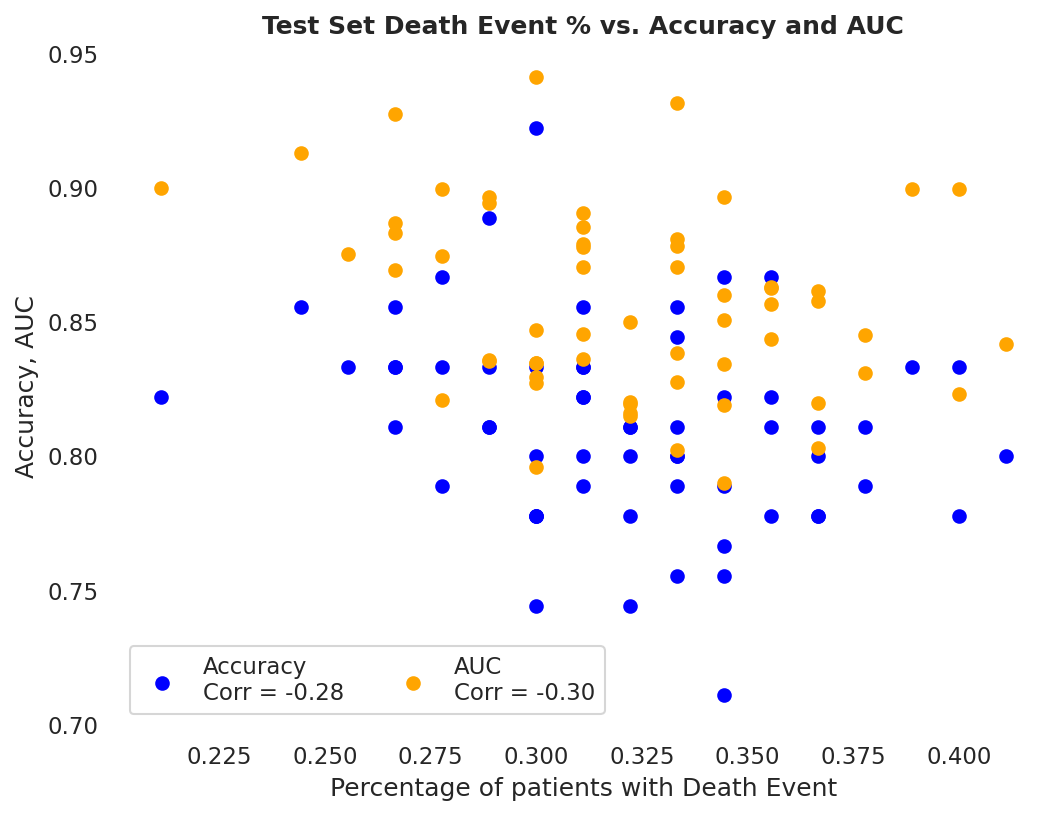

In [ ]:
# Average performance, initial dataset
acc_corr, _ = pearsonr(death_percent, accuracy)
print('Death Percent/Accuracy correlation: %.3f' % acc_corr)

auc_corr, _ = pearsonr(death_percent, auc)
print('Death Percent/AUC correlation: %.3f' % auc_corr)

colors = ['blue', 'orange']

plt.figure(figsize=(8,6))
ac = plt.scatter(death_percent, accuracy, color=colors[0])
au = plt.scatter(death_percent, auc, color=colors[1])
plt.xlabel('Percentage of patients with Death Event')
plt.ylabel('Accuracy, AUC')
plt.title('Test Set Death Event % vs. Accuracy and AUC', fontdict={'fontweight':'bold'})
plt.legend((ac, au),
           ('Accuracy\nCorr = {:.2f}'.format(acc_corr), 'AUC\nCorr = {:.2f}'.format(auc_corr)),
           scatterpoints=1,
           loc="lower left",
           ncol=3)

print('Average Accuracy: ', sum(accuracy)/len(accuracy))
print('Average AUC: ', sum(auc)/len(auc))
print('Max Accuracy', max(accuracy))
print('Max AUC', max(auc))

compare = {'Initial Data': [sum(accuracy)/len(accuracy), sum(auc)/len(auc), max(accuracy), max(auc)]}

In [ ]:
# Average performance, z score standardized
death_percent = []
accuracy = []
auc = []

for i in range(60):
  log_reg_lite(hf_z, i)

print('Average Accuracy: ', sum(accuracy)/len(accuracy))
print('Average AUC: ', sum(auc)/len(auc))
print('Max Accuracy', max(accuracy))
print('Max AUC', max(auc))

compare['Z-Scores'] = [sum(accuracy)/len(accuracy), sum(auc)/len(auc), max(accuracy), max(auc)]

Average Accuracy:  0.8181481481481483
Average AUC:  0.8676259231082494
Max Accuracy 0.8888888888888888
Max AUC 0.9429747207524986


In [ ]:
# Average performance, minmax standardized
death_percent = []
accuracy = []
auc = []

for i in range(60):
  log_reg_lite(hf_minmax, i)

print('Average Accuracy: ', sum(accuracy)/len(accuracy))
print('Average AUC: ', sum(auc)/len(auc))
print('Max Accuracy', max(accuracy))
print('Max AUC', max(auc))

compare['Min-Max'] = [sum(accuracy)/len(accuracy), sum(auc)/len(auc), max(accuracy), max(auc)]

Average Accuracy:  0.8242592592592592
Average AUC:  0.8766441123053806
Max Accuracy 0.9333333333333333
Max AUC 0.9659024103468548


In [ ]:
# Average performance, top features
death_percent = []
accuracy = []
auc = []

for i in range(60):
  log_reg_lite(hf_tops, i)

print('Average Accuracy: ', sum(accuracy)/len(accuracy))
print('Average AUC: ', sum(auc)/len(auc))
print('Max Accuracy', max(accuracy))
print('Max AUC', max(auc))

compare['Initial, Top 5'] = [sum(accuracy)/len(accuracy), sum(auc)/len(auc), max(accuracy), max(auc)]

Average Accuracy:  0.8194444444444443
Average AUC:  0.877414024365672
Max Accuracy 0.9
Max AUC 0.9541446208112875


In [ ]:
# Average performance, top features, z standardized
death_percent = []
accuracy = []
auc = []

for i in range(60):
  log_reg_lite(hf_z_tops, i)

print('Average Accuracy: ', sum(accuracy)/len(accuracy))
print('Average AUC: ', sum(auc)/len(auc))
print('Max Accuracy', max(accuracy))
print('Max AUC', max(auc))

compare['Z-Scores, Top 5'] = [sum(accuracy)/len(accuracy), sum(auc)/len(auc), max(accuracy), max(auc)]

Average Accuracy:  0.8194444444444441
Average AUC:  0.8784945337177863
Max Accuracy 0.9
Max AUC 0.9547325102880658


In [ ]:
# Average performance, top features, z standardized
death_percent = []
accuracy = []
auc = []

for i in range(60):
  log_reg_lite(hf_minmax, i)

print('Average Accuracy: ', sum(accuracy)/len(accuracy))
print('Average AUC: ', sum(auc)/len(auc))
print('Max Accuracy', max(accuracy))
print('Max AUC', max(auc))

compare['Min-max, Top 5'] = [sum(accuracy)/len(accuracy), sum(auc)/len(auc), max(accuracy), max(auc)]

Average Accuracy:  0.8242592592592592
Average AUC:  0.8766441123053806
Max Accuracy 0.9333333333333333
Max AUC 0.9659024103468548


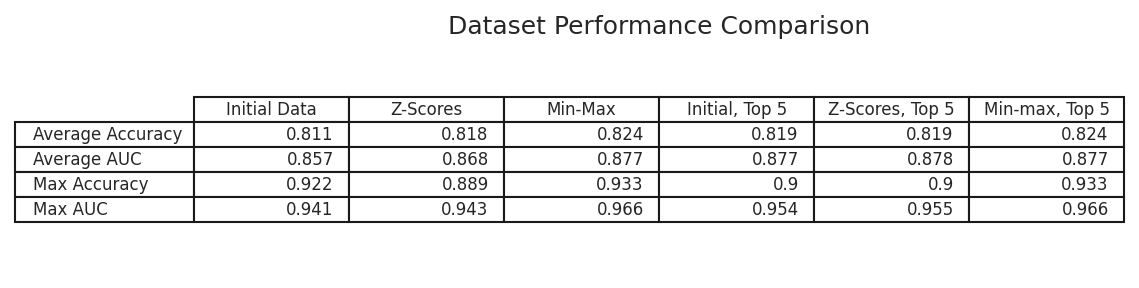

In [ ]:
compare_df = pd.DataFrame(data=compare, index=['Average Accuracy', 'Average AUC', 'Max Accuracy', 'Max AUC']).round(3)

fig = plt.figure(figsize = (8, 2))
ax = fig.add_subplot(111)

ax.table(cellText = compare_df.values,
          rowLabels = compare_df.index,
          colLabels = compare_df.columns,
          loc = 'center'
         )
ax.set_title('Dataset Performance Comparison')

ax.axis("off");

## Step by Step Logistic Regression

Split into train and test sets

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(
    heart_failure.drop(columns=['DEATH_EVENT', 'Death Label']), 
    heart_failure['DEATH_EVENT'], 
    test_size=.3,
    random_state=42)

Train logistic regression and predict test set

In [ ]:
lr = LogisticRegression(solver='lbfgs')
# train the model using the training data
clf = lr.fit(x_train, y_train)
# now that the model has been trained, predict the classes in the test set
pred = clf.predict(x_test)
# predict outputs labels, decision_function outputs the confidence scores
y_scores = clf.decision_function(x_test)
# print the accuracy sum(predicted == actual) / len(labels)
print('Predicted Class:\t', pred)
print('Actual Class: \t\t', y_test.to_numpy())
print('Accuracy: ', clf.score(x_test, y_test))

Predicted Class:	 [0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0
 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 1 0 1 1 0 0 0 1 1 0 1 0 0 0 0 0 0
 0 0 1 1 0 0 0 0 0 0 0 0 1 1 1 0]
Actual Class: 		 [0 0 1 1 0 0 1 0 1 0 0 1 1 0 0 1 0 0 1 1 0 0 0 1 1 0 0 0 1 0 1 0 0 1 1 1 1
 1 0 0 1 1 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 1 0 1 1 1 1 0 1 1 0 0 0 0 1 0 0 0
 0 0 0 1 0 0 1 1 0 0 0 0 1 1 1 0]
Accuracy:  0.8


Confusion matrix

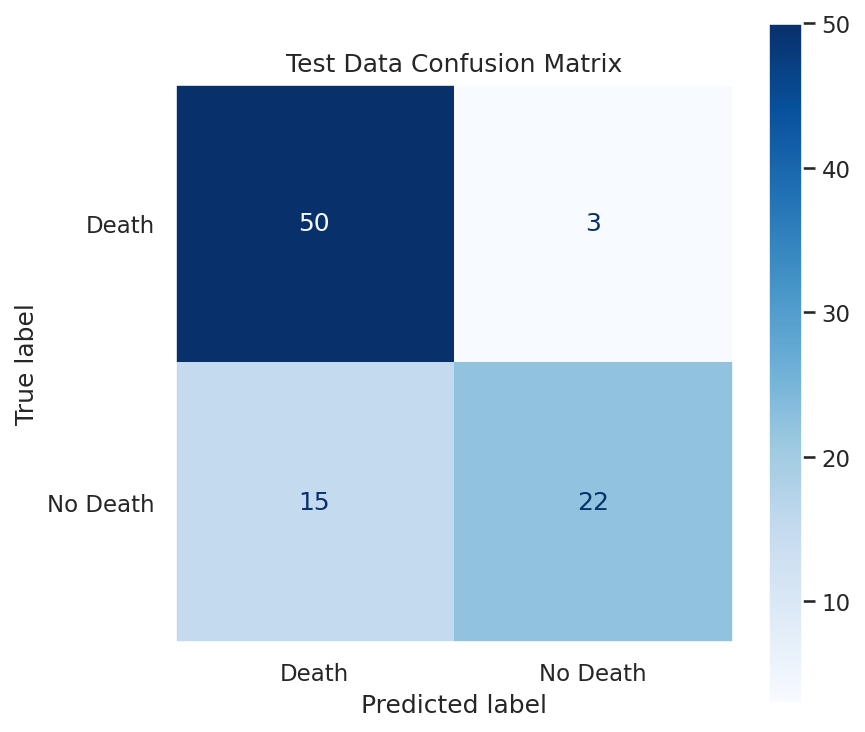

In [ ]:
disp = plot_confusion_matrix(clf, x_test, y_test,
                             display_labels=heart_failure['Death Label'].cat.categories,
                             cmap=plt.cm.Blues,
                             normalize=None)
disp.ax_.set_title('Test Data Confusion Matrix')
disp.ax_.grid(False)
disp.ax_.tick_params(axis='x')

_ = disp.confusion_matrix

ROC curve

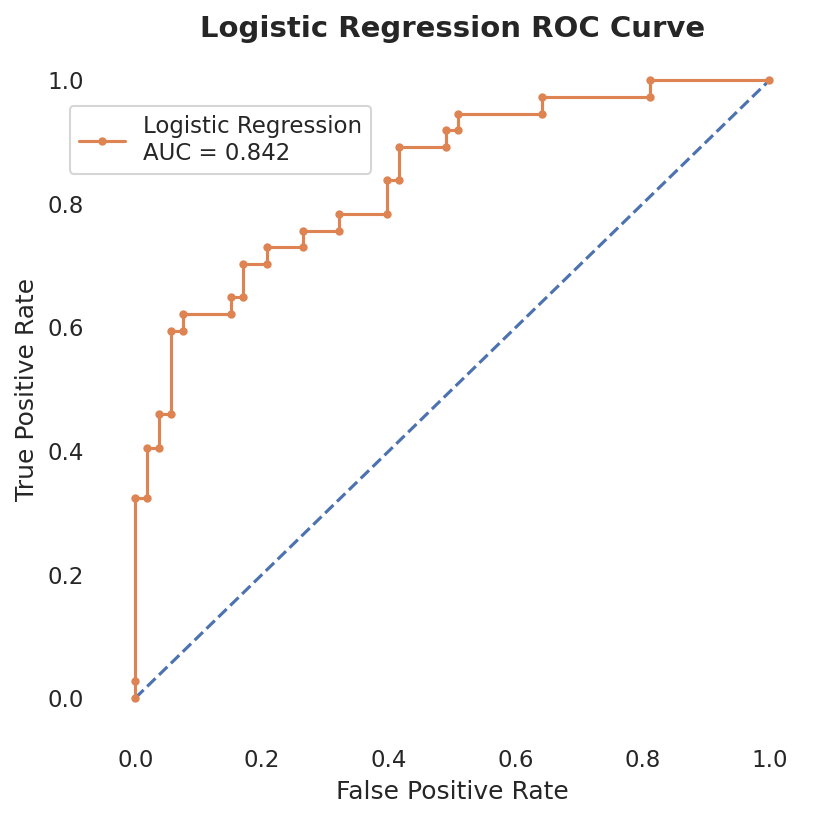

In [ ]:
# generate no skill prediction
ns_probs = [0 for _ in range(len(y_test))]
# predict probabilities
lr_probs = lr.predict_proba(x_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
plt.figure(figsize=(6,6))
plt.plot(ns_fpr, ns_tpr, linestyle='--')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic Regression\nAUC = {}'.format(round(lr_auc,3)))
# title
plt.title('Logistic Regression ROC Curve', fontdict={'fontsize': 14, 'fontweight':'bold'})
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend(loc="lower right", bbox_to_anchor=(.4, .8))
# show the plot
plt.show()